In [ ]:
import os
import time
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model



In [ ]:
def generate_random_image(shape = (96, 96 , 3), seed = None):
    return tf.random.uniform(shape = shape, minval = 0, maxval = 1, dtype= tf.dtypes.float32, seed = seed)

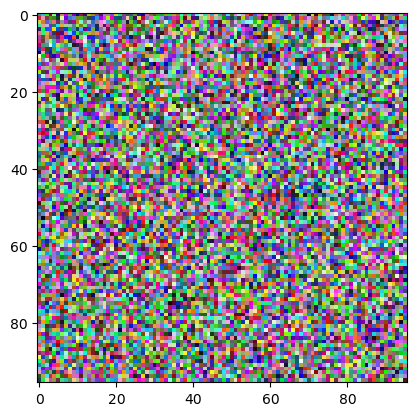

In [ ]:
img = generate_random_image()
plt.imshow(img)

In [ ]:
def create_submodel(model = None, layer_name = None, verbose = True):
    submodel = Model(inputs = model.input, outputs = model.get_layer(layer_name).output)
    if verbose:
        submodel.summary()
        
    return submodel

In [ ]:
from tensorflow.keras.applications import VGG19

vgg19 = VGG19(input_shape= (96, 96, 3), include_top= False, weights = 'imagenet')
submodel = create_submodel(vgg19, 'block1_conv2', verbose = True)

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def normalize_tensor(tensor):
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    normalized_tensor = tf.math.divide(tf.subtract(tensor, min_val), tf.subtract(max_val, min_val))
    return normalized_tensor


In [ ]:
def train_filter(input_img, model, filter_index = None, epochs = 30, step = 10, verbose = False, log_rate = 0.2):
    losses = []
    for i in range(epochs):
        
        with tf.GradientTape() as tape:
            loss = 0
            tape.watch(input_img)
            output = model(tf.expand_dims(input_img, axis = 0))[:,:,:, filter_index]
            loss = tf.math.reduce_mean(output)
            
            if verbose:
                if i % int(epochs * log_rate) == 0:
                    losses.append(float(loss))
                    print(f'EPOCH {i} LOSS : {float(loss)}')
            
        grads = tape.gradient(loss, input_img)
        grads = tf.math.l2_normalize(grads)
        input_img += grads * step
        
        input_img = normalize_tensor(input_img)
    
    return input_img, losses


EPOCH 0 LOSS : 1.0510584115982056
EPOCH 20 LOSS : 2.8120908737182617
EPOCH 40 LOSS : 2.8532354831695557
EPOCH 60 LOSS : 2.859806537628174
EPOCH 80 LOSS : 2.8597140312194824
6.551880121231079


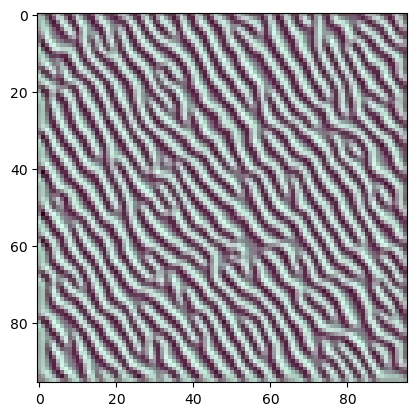

In [ ]:
beg = time.time()
newimg,_ = train_filter(img, submodel, 5,epochs = 100, verbose = True)
print(time.time() - beg)
newimg = tf.cast(255 * newimg, dtype=tf.int32).numpy()


plt.imshow(newimg)

In [ ]:
def visualize_filters_in_layer(input_img, submodel, layer_name, n_filters = -1, 
                               epochs = 30, step = 10, fig_size = (10,10)):

    #for layer_idx, layer_name in enumerate(layer_names):
        # create a submodel for each layer
        #submodel = create_submodel(model, layer_name, verbose = False)

    total_layer_filters = submodel.output_shape[-1]
    if n_filters == -1:
        n_filters = total_layer_filters 
    
    print(f'Processing {n_filters} filters in {layer_name} layer')

    if n_filters <= 8:
        rows = 2
    elif n_filters <= 32:
        rows = 4
    else:
        rows = 8
    
    cols = n_filters // rows
    #print(n_filters)
    #print(cols)
    fig = plt.figure(figsize = fig_size )
    
    if n_filters == total_layer_filters:
        for filter_idx in range(n_filters):      
            filter,_  = train_filter(input_img, submodel, filter_index = filter_idx, 
                                        epochs = 30, step = 10, verbose = False)
            fig.add_subplot(rows, cols, filter_idx + 1)
            plt.subplots_adjust(hspace=0.6)
            plt.imshow(filter)
            plt.axis('off')
            plt.title(str(filter_idx), pad = 10)
    else:
        random_filter_idxs = sorted([random.randint(0, total_layer_filters-1) for _ in range(n_filters)])
        #print(random_filter_idxs)
        for i, filter_idx in enumerate(random_filter_idxs):      
            filter,_  = train_filter(input_img, submodel, filter_index = filter_idx, 
                                        epochs = 30, step = 10, verbose = False)
        
            fig.add_subplot(rows, cols, i + 1)
            #plt.subplots_adjust(hspace=0.6)
            plt.imshow(filter)
            plt.axis('off')
            plt.title(str(filter_idx), pad = 1)

    
    # Set the figure title
    fig.suptitle(f'{layer_name} filters ( {n_filters} / {total_layer_filters})')
    # Save the figure to a file
    plt.savefig(layer_name + ' filters.png')  # Save as PNG format

Processing 64 filters in block1_conv2 layer


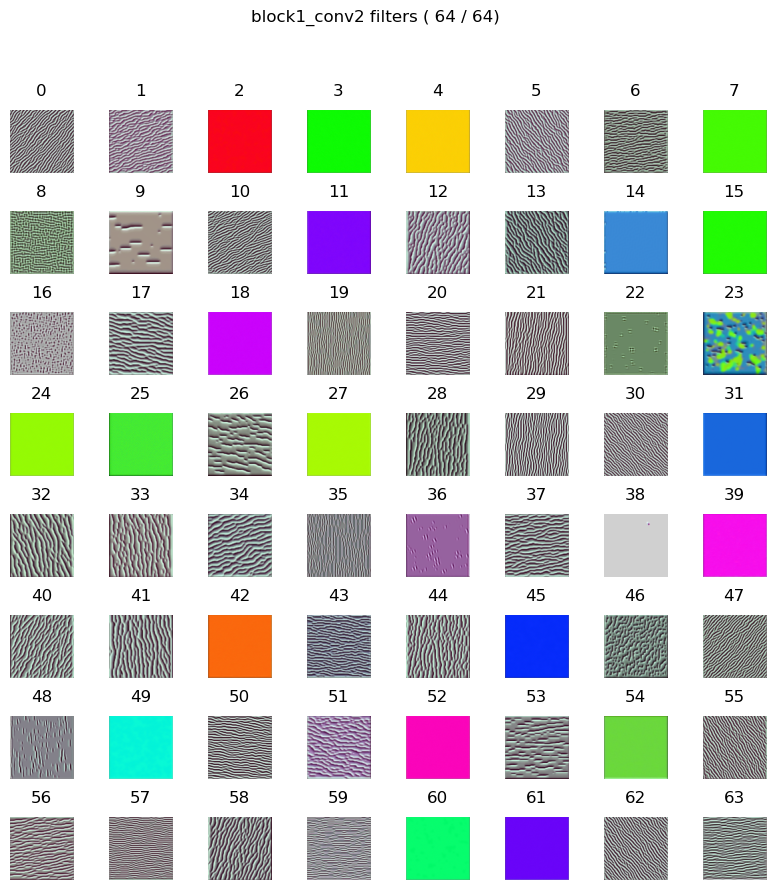

In [ ]:
visualize_filters_in_layer(input_img = img, submodel = submodel, 
                       layer_name = 'block1_conv2', n_filters = -1, epochs = 30, 
                       step = 10, fig_size = (10,10))

In [ ]:
def save_all_filters(input_img, model, layer_names =[], n_filters = 16, 
                     epochs = 30, step = 10, fig_size = (10,10)):

    for layer_name in layer_names:

        submodel = create_submodel(model, layer_name, verbose = False)

        visualize_filters_in_layer(input_img, submodel, 
                       layer_name, n_filters = n_filters, epochs = 30, 
                       step = 10, fig_size = (10,10))
        



In [ ]:
layer_names = [layer.name for layer in vgg19.layers if 'conv' in layer.name]
print(layer_names)
save_all_filters(input_img = img, layer_names = layer_names, 
                 model = vgg19, n_filters = 16, 
                 epochs = 30, step = 10
                 )

In [ ]:
!zip -r outputs.zip {os.getcwd()}

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/block2_conv1 filters.png (deflated 1%)
  adding: kaggle/working/block2_conv2 filters.png (deflated 1%)
  adding: kaggle/working/block5_conv3 filters.png (deflated 2%)
  adding: kaggle/working/block5_conv1 filters.png (deflated 1%)
  adding: kaggle/working/block5_conv2 filters.png (deflated 1%)
  adding: kaggle/working/block1_conv2 filters.png (deflated 2%)
  adding: kaggle/working/block3_conv2 filters.png (deflated 1%)
  adding: kaggle/working/block1_conv1 filters.png (deflated 2%)
  adding: kaggle/working/block3_conv4 filters.png (deflated 1%)
  adding: kaggle/working/block3_conv1 filters.png (deflated 1%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/block4_conv1 filters.png (deflated 1%)
  adding: kaggle/working/block3_conv3 filters.png (deflated 1%)
  adding: kaggle/working/block5_conv4 filters.png (deflated 2%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  addin